# Model final: Predir el preu

In [ ]:
import pandas as pd
import requests, io
import numpy as np
import seaborn as sns
import geopy.distance
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential, save_model, load_model
from keras.layers import Embedding, LSTM, Dense, Flatten, Bidirectional, Dropout
from keras.regularizers import l2, l1
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Read Data

In [ ]:
data = pd.read_csv('https://github.com/paubernabe/data/blob/main/juliol.csv?raw=true')
print(data.shape)
data.head(5)

(17079, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20210707180233,2021-07-07,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,https://www.airbnb.com/users/show/71615,Mireia And Maria,2010-01-19,"Barcelona, Catalonia, Spain","We are Mireia (43) & Maria (45), two multiling...",within an hour,98%,81%,f,https://a0.muscache.com/im/users/71615/profile...,https://a0.muscache.com/im/users/71615/profile...,la Sagrada Família,34.0,34.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.40556,2.17262,Entire apartment,Entire home/apt,8,NaN,2 baths,3.0,6.0,"[""Washer"", ""Host greets you"", ""Iron"", ""Hair dr...",$169.00,1,1125,1.0,3.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,0,0,60,2021-07-07,21,0,0,2014-03-02,2019-10-11,4.40,4.55,4.75,4.80,4.90,4.75,4.30,HUTB-002062,t,18,18,0,0,0.23
1,23197,https://www.airbnb.com/rooms/23197,20210707180233,2021-07-08,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...",Strategically located in the Parc del Fòrum ar...,https://a0.muscache.com/pictures/738532/806da1...,90417,https://www.airbnb.com/users/show/90417,Etain (Marnie),2010-03-09,"Catalonia, Spain","Hi. I'm Etain, though everyone calls me by my...",within a few hours,100%,67%,f,https://a0.muscache.com/im/users/90417/profile...,https://a0.muscache.com/im/users/90417/profile...,El Besòs i el Maresme,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,41.41291,2.22063,Entire apartment,Entire home/apt,6,NaN,2 baths,3.0,5.0,"[""Washer"", ""Iron"", ""Hair dryer"", ""Security cam...",$240.00,3,300,3.0,6.0,1125.0,1125.0,3.5,1125.0,NaN,t,17,47,77,169,2021-07-08,52,0,0,2016-01-05,2019-12-15,4.74,4.92,4.92,4.94,4.98,4.67,4.69,HUTB-005057,f,2,2,0,0,0.78
2,32711,https://www.airbnb.com/rooms/32711,20210707180233,2021-07-08,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,https://www.airbnb.com/users/show/135703,Nick,2010-05-31,"Barcelona, Catalonia, Spain",I'm Nick your English host in Barcelona.\r\n\r...,within a day,83%,100%,f,https://a0.muscache.com/im/users/135703/profil...,https://a0.muscache.com/im/users/135703/profil...,Camp d'en Grassot i Gràcia Nova,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Barcelona, Catalonia, Spain",el Camp d'en Grassot i Gràcia Nova,Gràcia,41.40566,2.1

In [ ]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

## Clean data

In [ ]:
'''
S'eliminen identificadors i dades que no tenen rellevància
'''
data = data.drop(['scrape_id', 'last_scraped', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                  'host_neighbourhood', 'calendar_updated'],axis=1)

In [ ]:
'''
Eliminem els caràcters no desitjats en els camps
'''
def clean_str(x):
    if (type(x) == str):
      x = x.replace("$", "").replace(",", "").replace(" ", "").replace("%", "")
    return float(x)



d = {'t': True, 'f': False}
data['host_has_profile_pic'] = data['host_has_profile_pic'].map(d)
data['host_is_superhost'] = data['host_is_superhost'].map(d)  
data['host_identity_verified'] = data['host_identity_verified'].map(d)
data['has_availability'] = data['has_availability'].map(d)
data['instant_bookable'] = data['instant_bookable'].map(d)

data['price'] = data['price'].apply(clean_str)
data['host_acceptance_rate'] = data['host_acceptance_rate'].apply(clean_str)
data['host_response_rate'] = data['host_response_rate'].apply(clean_str)

### Distància al centre

La fórmula del semiversinus o fórmula del haversine és una important equació per a la navegació astronòmica, pel que fa al càlcul de la distància de cercle màxim entre dos punts d'un globus sabent la seva longitud i la seva latitud.

En aquesta funció es calcula la distància que hi ha de cada apartament al centre. Definim **com a centre** de Barcelona, la Plaça de Catalunya.

In [ ]:
def haversine_distance(lat1, lon1, lat2 = 41.3870154 , lon2 = 2.1700471):
  coords_1 = (lat1, lon1)
  coords_2 = (lat2, lon2)
  return geopy.distance.vincenty(coords_1, coords_2).km

In [ ]:
data['distance'] = data.apply(lambda row : haversine_distance(row['latitude'],
                                  row['longitude']), axis = 1)

In [ ]:
def bar_plot_object(title,data):
  x = list(data.value_counts().keys())
  x = x[::-1]
  y = list(data.value_counts())
  y = y[::-1]
  plt.barh(x,y)
  plt.title(title)
  return None


def explore_col(data, column):
  bar_plot_object(column+" histogram",data[column])
  print(column,'description\n', data[column].describe())
  print('Top 5 frequent:',data[column].value_counts()[:5].index.tolist())


### Data engineering

- Dealing with NaN

In [ ]:
for c in data.columns:
  na = data[c].isnull().sum()
  if na > 0:
    print(c, na)
    if na > 1000:
      del data[c]

name 10
description 132
neighborhood_overview 6678
host_since 49
host_response_time 4746
host_response_rate 4746
host_acceptance_rate 5243
host_is_superhost 49
host_listings_count 49
host_total_listings_count 49
host_has_profile_pic 49
host_identity_verified 49
neighbourhood 6678
bathrooms 17079
bathrooms_text 20
bedrooms 575
beds 341
minimum_minimum_nights 1
maximum_minimum_nights 1
minimum_maximum_nights 1
maximum_maximum_nights 1
minimum_nights_avg_ntm 1
maximum_nights_avg_ntm 1
first_review 5095
last_review 5095
review_scores_rating 5095
review_scores_accuracy 5292
review_scores_cleanliness 5289
review_scores_checkin 5295
review_scores_communication 5290
review_scores_location 5296
review_scores_value 5297
license 6428
reviews_per_month 5095


In [ ]:
for c in data.columns:
  na = data[c].isnull().sum()
  if na > 0:
    print(c, na)

name 10
description 132
host_since 49
host_is_superhost 49
host_listings_count 49
host_total_listings_count 49
host_has_profile_pic 49
host_identity_verified 49
bathrooms_text 20
bedrooms 575
beds 341
minimum_minimum_nights 1
maximum_minimum_nights 1
minimum_maximum_nights 1
maximum_maximum_nights 1
minimum_nights_avg_ntm 1
maximum_nights_avg_ntm 1


In [ ]:
#data['review_scores_rating'] = data['review_scores_rating'].fillna(data['review_scores_rating'].mean())

- Dummy variables


In [ ]:
y = pd.get_dummies(data.room_type, prefix='rt')
type(y)
data = data.join(y)

y = pd.get_dummies(data.property_type, prefix='property')
type(y)
data = data.join(y)

y = pd.get_dummies(data.host_is_superhost, prefix='superhost')
type(y)
data = data.join(y)

y = pd.get_dummies(data.neighbourhood_group_cleansed, prefix='nb')
type(y)
data = data.join(y)

y = pd.get_dummies(data.instant_bookable, prefix='ib')
type(y)
data = data.join(y)


- Outliers

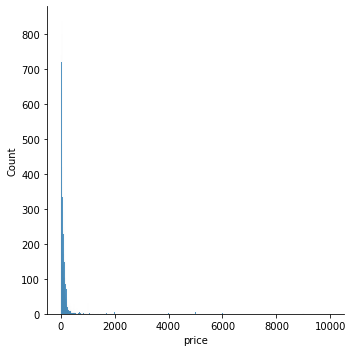

In [ ]:
sns.displot(data, x="price", binwidth=3)

In [ ]:
print(data['price'].min(), data['price'].max(), data['price'].mean())

0.0 9999.0 115.01399379354763


In [ ]:
print(len(data[data['price'] > 350]))

542


In [ ]:
print(len(data[data['price'] < 10]))

48


In [ ]:
data = data[data['price'] < 350]

In [ ]:
data = data[data['price'] > 10]

In [ ]:
print(data['price'].min(), data['price'].max(), data['price'].mean())

11.0 349.0 89.21699720160603


- Nombre d'amenities que té l'apartament

In [ ]:
import ast
def len_amenities(x):

  return len(ast.literal_eval(x))


data['amenities_len'] = data['amenities'].apply(len_amenities)

- Lavabos


Els lavabos són una part rellevant de l'apartament, però en les dades la columna de nombre de lavabos és tota nul·la.
No obstant això, es pot agafar la informació de la columna 'bathroom-text'.



In [ ]:
#data['bathrooms'].isna().sum()

In [ ]:
data['bathrooms_text'].value_counts()

1 bath               6404
1 shared bath        3587
2 baths              2585
1 private bath       1155
1.5 shared baths      773
1.5 baths             717
2 shared baths        572
3 baths               162
2.5 baths             100
2.5 shared baths       68
3 shared baths         54
0 shared baths         37
4 baths                32
Shared half-bath       31
3.5 baths              26
Half-bath              23
0 baths                22
3.5 shared baths       14
11 shared baths        14
5 baths                10
5.5 baths              10
4 shared baths         10
Private half-bath       5
7 shared baths          3
6 baths                 2
4.5 shared baths        2
5 shared baths          2
7.5 shared baths        1
7.5 baths               1
Name: bathrooms_text, dtype: int64

Es creen dues noves categories: lavabo privat i lavabo compartit.

In [ ]:
import re

def parse_bathroom_shared(x):
  if type(x) == str:
    if 'shared' in x.lower():
      b = re.findall("\d+", x)
      if len(b) == 0:
        #return float('nan')
        return 1
      if len(b) == 1:
        return int(b[0])
      if len(b) > 1:
        return float(b[0]) + float('0.'+b[1])
  return 0

def parse_bathroom(x):
  if type(x) == str:
    if 'shared' not in x.lower():
      b = re.findall("\d+", x)
      if len(b) == 0:
        #return float('nan')
        return 1
      if len(b) == 1:
        return int(b[0])
      if len(b) > 1:
        return float(b[0]) + float('0.'+b[1])
  return 0
  

data['private_bath'] = data['bathrooms_text'].apply(parse_bathroom)
data['shared_bath'] = data['bathrooms_text'].apply(parse_bathroom_shared)
#del data['bathrooms']

In [ ]:
data['private_bath'].value_counts()

1.0    7587
0.0    5206
2.0    2585
1.5     717
3.0     162
2.5     100
4.0      32
3.5      26
5.0      10
5.5      10
6.0       2
7.5       1
Name: private_bath, dtype: int64

In [ ]:
data['shared_bath'].value_counts()

0.0     11307
1.0      3618
1.5       773
2.0       572
2.5        68
3.0        54
11.0       14
3.5        14
4.0        10
7.0         3
5.0         2
4.5         2
7.5         1
Name: shared_bath, dtype: int64

In [ ]:
'''data = data[data['private_bath'] <= 3]
data = data[data['shared_bath'] <= 2]'''

"data = data[data['private_bath'] <= 3]\ndata = data[data['shared_bath'] <= 2]"

In [ ]:
data.head()['distance']

0    2.070802
1    5.115021
2    2.070717
3    0.829528
4    0.955614
Name: distance, dtype: float64

In [ ]:
'''datanum =datanum.drop('review_scores_rating', axis=1)
datanum =datanum.drop('review_scores_accuracy', axis=1)
datanum =datanum.drop('review_scores_cleanliness', axis=1)
datanum =datanum.drop('review_scores_checkin', axis=1)
datanum =datanum.drop('review_scores_communication', axis=1)
datanum =datanum.drop('review_scores_location', axis=1)
datanum =datanum.drop('review_scores_value', axis=1)'''

"datanum =datanum.drop('review_scores_rating', axis=1)\ndatanum =datanum.drop('review_scores_accuracy', axis=1)\ndatanum =datanum.drop('review_scores_cleanliness', axis=1)\ndatanum =datanum.drop('review_scores_checkin', axis=1)\ndatanum =datanum.drop('review_scores_communication', axis=1)\ndatanum =datanum.drop('review_scores_location', axis=1)\ndatanum =datanum.drop('review_scores_value', axis=1)"

In [ ]:
#cols = ['review_scores_accuracy','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin' ,'review_scores_communication', 'review_scores_location', 'review_scores_value']
#review_scores_rating!!!

#data[cols] = data[cols].fillna(0)

## Transports i serveis

S'utilitzen dos conjunts de dades de la web https://opendata-ajuntament.barcelona.cat/es/ que ens donen informació sobre el transport(metro, rodalies, etc) i els serveis (bars i restaurants) que hi han a cada districte.

In [ ]:
transport = pd.read_csv('https://github.com/paubernabe/data/blob/main/TRANSPORTS.csv?raw=true')
print(transport.shape)
transport.head(5)

(642, 16)


,CODI_CAPA,CAPA_GENERICA,NOM_CAPA,ED50_COORD_X,ED50_COORD_Y,ETRS89_COORD_X,ETRS89_COORD_Y,LONGITUD,LATITUD,EQUIPAMENT,DISTRICTE,BARRI,NOM_DISTRICTE,NOM_BARRI,ADRECA,TELEFON
0,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,428480.365,4586484.614,428388.453,4586283.641,2.142987,41.424923,"METRO (L3, L5) - VALL D'HEBRON (C. de les Bass...",7.0,41.0,Horta-Guinardó,la Vall d'Hebron,NaN,NaN
1,K002,Transports i serveis relacionats,Ferrocarrils Generalitat (FGC),429726.943,4582853.670,429635.018,4582652.730,2.158326,41.392331,FGC - PROVENÇA (C. de Provença)-,2.0,8.0,Eixample,l'Antiga Esquerra de l'Eixample,NaN,NaN
2,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,426477.889,4583649.008,426385.994,4583448.062,2.119370,41.399203,FGC (L6) - REINA ELISENDA (Sortida Duquesa d'O...,5.0,23.0,Sarrià-Sant Gervasi,Sarrià,NaN,NaN
3,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,427818.595,4583478.761,427726.688,4583277.816,2.135427,41.397791,FGC (L6) - LA BONANOVA-,5.0,26.0,Sarrià-Sant Gervasi,Sant Gervasi - Galvany,NaN,NaN
4,K001,Transports i serveis relacionats,Metro i línies urbanes FGC,432051.444,4589400.176,431959.500,4589199.175,2.185391,41.451492,METRO (L11) - CASA DE L'AIGUA (C. Vila-Real)-,8.0,53.0,Nou Barris,la Trinitat Nova,NaN,NaN


El que es fa és sumar el nombre de serveis que pertanyen a un districte en concret. Amb el transport es fa el mateix.

In [ ]:
tr = transport['NOM_DISTRICTE'].value_counts()

numtransp = pd.DataFrame([tr]).T
numtransp =numtransp.reset_index()
numtransp.columns = ['name', 'number']
numtransp

,name,number
0,Eixample,120
1,Sant Martí,70
2,Sarrià-Sant Gervasi,57
3,Sants-Montjuïc,53
4,Sant Andreu,40
5,Nou Barris,39
6,Horta-Guinardó,31
7,Ciutat Vella,27
8,Les Corts,24
9,Gràcia,17


In [ ]:
def transport_num(x):
  if type(x) == str:
    tmp = numtransp.loc[numtransp['name'] == x]
    return tmp['number'].values[0]
  return 0

data['transport'] = data['neighbourhood_group_cleansed'].apply(transport_num)

In [ ]:
'''def transport_near(lat, lon):
  NEAR = 0.4
  cnt_near = 0
  for idx, t in transport.iterrows():
    h_distance = haversine_distance(t['LATITUD'], t['LONGITUD'], lat, lon)
    if h_distance <= NEAR:
      cnt_near += 1
  
  return cnt_near


data['transport_near'] = data.apply(lambda row : transport_near(row['latitude'],
                                  row['longitude']), axis = 1)'''


"def transport_near(lat, lon):\n  NEAR = 0.4\n  cnt_near = 0\n  for idx, t in transport.iterrows():\n    h_distance = haversine_distance(t['LATITUD'], t['LONGITUD'], lat, lon)\n    if h_distance <= NEAR:\n      cnt_near += 1\n  \n  return cnt_near\n\n\ndata['transport_near'] = data.apply(lambda row : transport_near(row['latitude'],\n                                  row['longitude']), axis = 1)"

In [ ]:
restaurants = pd.read_csv('https://github.com/paubernabe/data/blob/main/rest.csv?raw=true')
print(restaurants.shape)
restaurants.head(5)

(2504, 36)


,register_id,name,institution_id,institution_name,created,modified,addresses_roadtype_id,addresses_roadtype_name,addresses_road_id,addresses_road_name,addresses_start_street_number,addresses_end_street_number,addresses_neighborhood_id,addresses_neighborhood_name,addresses_district_id,addresses_district_name,addresses_zip_code,addresses_town,addresses_main_address,addresses_type,values_id,values_attribute_id,values_category,values_attribute_name,values_value,values_outstanding,values_description,secondary_filters_id,secondary_filters_name,secondary_filters_fullpath,secondary_filters_tree,secondary_filters_asia_id,geo_epgs_25831_x,geo_epgs_25831_y,geo_epgs_4326_x,geo_epgs_4326_y
0,﻿2122182514,Restaurant Chido One,NaN,NaN,2002-05-02T00:00:00+02:00,2021-03-03T22:14:06.509761+01:00,NaN,NaN,341908,C Torrijos,30.0,NaN,31,la Vila de Gràcia,6,Gràcia,8012,BARCELONA,True,NaN,134757.0,20001.0,Telèfons,Tel.,932850335,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,429706.567847,4.583870e+06,41.403301,2.159041
1,﻿2064171550,Labona Pizza *Gal·lileu,NaN,NaN,2002-03-05T00:00:00+01:00,2021-07-21T12:29:38.986716+02:00,NaN,NaN,138802,Carrer de Galileu,326.0,NaN,19,les Corts,4,Les Corts,8028,Barcelona,True,NaN,134615.0,20001.0,Telèfons,Tel.,933222040,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,427366.054990,4.581993e+06,41.386187,2.131268
2,﻿99400276550,Restaurant Pez Vela Chiringuito,NaN,NaN,2011-09-02T12:07:02+02:00,2021-03-03T22:14:28.487962+01:00,NaN,NaN,701644,Pg Mare Nostrum,19.0,NaN,3,la Barceloneta,1,Ciutat Vella,8039,BARCELONA,True,NaN,224661.0,20001.0,Telèfons,Tel.,932216317,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,432247.321931,4.580054e+06,41.369151,2.189861
3,﻿99400264196,Restaurant Udon *Glòries,NaN,NaN,2011-02-07T00:00:00+01:00,2021-03-03T22:14:49.237116+01:00,NaN,NaN,144601,Av Diagonal,208.0,NaN,66,el Parc i la Llacuna del Poblenou,10,Sant Martí,8018,BARCELONA,True,NaN,223254.0,20001.0,Telèfons,Tel.,934861314,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,432506.888609,4.584029e+06,41.404976,2.192521
4,﻿75990341919,Bar Restaurant Marcelino 16 *Diputació,NaN,NaN,1996-09-18T00:00:00+02:00,2021-03-03T22:14:35.713828+01:00,NaN,NaN,100800,C Diputació,41.0,NaN,9,la Nova Esquerra de l'Eixample,2,Eixample,8015,BARCELONA,True,NaN,149688.0,20001.0,Telèfons,Tel.,934246267,True,NaN,60731068,Restaurants,Planol BCN >> Restaurants >> Restaurants >> Re...,651,65103007000000,429109.288208,4.581221e+06,41.379388,2.152206


In [ ]:
tr = restaurants['addresses_district_name'].value_counts()

rest = pd.DataFrame([tr]).T
rest =rest.reset_index()
rest.columns = ['name', 'number']
rest

,name,number
0,Eixample,846
1,Ciutat Vella,558
2,Sarrià-Sant Gervasi,273
3,Sant Martí,198
4,Gràcia,191
5,Sants-Montjuïc,189
6,Les Corts,115
7,Sant Andreu,63
8,Horta-Guinardó,46
9,Nou Barris,25


In [ ]:
def restaurants_num(x):
  if type(x) == str:
    tmp = rest.loc[rest['name'] == x]
    if tmp.empty:
      return 0
    return tmp['number'].values[0]
  return 0

data['restaurants'] = data['neighbourhood_group_cleansed'].apply(restaurants_num)

## Sentiment analysis data


A partir de les dades generades a partir del model d'anàlisi de sentiment, es creen noves característiques per tal de millorar el rendiment dels models.

In [ ]:
raw_sentiment = pd.read_csv('https://github.com/paubernabe/data/blob/main/sentiment_analysis2.csv.gz?raw=true', compression='gzip')

In [ ]:
raw_sentiment.head()

,id,Review,Sentiment
0,18674,great location clean spacious flat would reco...,1
1,18674,mi mejor recomendación para este departamento...,1
2,18674,big apartment well equipped very good service...,1
3,18674,the check in was fast and flexible the price ...,0
4,18674,great location and enough space in the apartm...,1


In [ ]:
unique_ids = raw_sentiment['id'].unique()
len(unique_ids)

11625

In [ ]:
processed_sentiment = pd.DataFrame(columns = ['id', 'positive', 'negative', 'pos_ratio', 'neg_ratio', 'n_total'])
processed_sentiment['id'] = unique_ids

In [ ]:
def process_sentiment_data(raw, processed):

  for idx, row in processed.iterrows():

    id = row['id']

    total = raw[raw['id'] == id]
    processed.at[idx,'n_total'] = len(total)

    positive = len(total[total['Sentiment'] == 1]['Sentiment'])
    negative = len(total[total['Sentiment'] == 0]['Sentiment'])

    processed.at[idx,'positive'] = positive
    processed.at[idx,'negative'] = negative

    processed.at[idx,'pos_ratio'] = round(positive / len(total), 2)
    processed.at[idx,'neg_ratio'] = round(negative / len(total), 2)





In [ ]:
process_sentiment_data(raw_sentiment, processed_sentiment)

In [ ]:
processed_sentiment.head()

,id,positive,negative,pos_ratio,neg_ratio,n_total
0,18674,18,3,0.86,0.14,21
1,23197,49,1,0.98,0.02,50
2,32711,61,2,0.97,0.03,63
3,34981,144,8,0.95,0.05,152
4,35379,348,9,0.97,0.03,357


In [ ]:
data = pd.merge(data, processed_sentiment, on = "id")

In [ ]:
data

,id,listing_url,name,description,picture_url,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,...,property_Room in boutique hotel,property_Room in hostel,property_Room in hotel,property_Room in serviced apartment,property_Shared room in apartment,property_Shared room in bed and breakfast,property_Shared room in condominium,property_Shared room in floor,property_Shared room in guest suite,property_Shared room in guesthouse,property_Shared room in hostel,property_Shared room in hotel,property_Shared room in house,property_Shared room in loft,property_Shared room in serviced apartment,property_Tiny house,superhost_False,superhost_True,nb_Ciutat Vella,nb_Eixample,nb_Gràcia,nb_Horta-Guinardó,nb_Les Corts,nb_Nou Barris,nb_Sant Andreu,nb_Sant Martí,nb_Sants-Montjuïc,nb_Sarrià-Sant Gervasi,ib_False,ib_True,amenities_len,private_bath,shared_bath,transport,restaurants,positive,negative,pos_ratio,neg_ratio,n_total
0,18674,https://www.airbnb.com/rooms/18674,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,https://a0.muscache.com/pictures/13031453/413c...,2010-01-19,False,34.0,34.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",True,True,la Sagrada Família,Eixample,41.405560,2.172620,Entire apartment,Entire home/apt,8,2 baths,3.0,6.0,"[""Washer"", ""Host greets you"", ""Iron"", ""Hair dr...",169.0,1,1125,1.0,3.0,1125.0,1125.0,2.0,1125.0,True,0,0,0,60,2021-07-07,21,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,19,2.0,0.0,120,846,18,3,0.86,0.14,21
1,23197,https://www.airbnb.com/rooms/23197,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...",https://a0.muscache.com/pictures/738532/806da1...,2010-03-09,False,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",True,True,el Besòs i el Maresme,Sant Martí,41.412910,2.220630,Entire apartment,Entire home/apt,6,2 baths,3.0,5.0,"[""Washer"", ""Iron"", ""Hair dryer"", ""Security cam...",240.0,3,300,3.0,6.0,1125.0,1125.0,3.5,1125.0,True,17,47,77,169,2021-07-08,52,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,35,2.0,0.0,70,198,49,1,0.98,0.02,50
2,32711,https://www.airbnb.com/rooms/32711,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,https://a0.muscache.com/pictures/357b25e4-f414...,2010-05-31,False,5.0,5.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",True,True,el Camp d'en Grassot i Gràcia Nova,Gràcia,41.405660,2.170150,Entire apartment,Entire home/apt,6,1.5 baths,2.0,3.0,"[""Washer"", ""Iron"", ""Hair dryer"", ""Security cam...",144.0,2,31,2.0,2.0,31.0,31.0,2.0,31.0,True,0,0,0,8,2021-07-08,63,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,32,1.5,0.0,17,191,61,2,0.97,0.03,63
3,34981,https://www.airbnb.com/rooms/34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,Spacious apartment for large families or group...,https://a0.muscache.com/pictures/c4d1723c-e479...,2010-01-24,True,3.0,3.0,"['email', 'phone', 'reviews', 'manual_offline'...",True,True,el Barri Gòtic,Ciutat Vella,41.379780,2.176230,Entire apartment,Entire home/apt,9,3 baths,4.0,6.0,"[""Washer"", ""Extra pillows and blankets"", ""Iron...",283.0,4,365,1.0,4.0,365.0,365.0,3.9,365.0,True,11,27,57,148,2021-07-07,150,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,39,3.0,0.0,27,558,144,8,0.95,0.05,152
4,35379,https://www.airbnb.com/rooms/35379,Double 04 CasanovaRooms Barcelona,Room at a my

### numeric data only

In [ ]:
datanum = data._get_numeric_data()
'''corrmat = datanum.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(100,100))
#plot heat map
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")'''

'corrmat = datanum.corr()\ntop_corr_features = corrmat.index\nplt.figure(figsize=(100,100))\n#plot heat map\nsns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")'

In [ ]:
#datanum[cols] = datanum[cols].fillna(0)
#datanum =datanum.drop(['bathrooms'], axis=1)

## Feature selection

In [ ]:
df_select = datanum.dropna()
y_select = df_select['price']
X_select = df_select.drop('price', axis=1)

- Select K best

In [ ]:
#SelectKBest

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, mutual_info_regression

select = SelectKBest(score_func=f_regression, k=20)
z = select.fit_transform(X_select,y_select)


print("After selecting best n features:", z.shape)


filter = select.get_support()

X_select.columns[filter]

After selecting best n features: (10214, 20)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Index(['host_listings_count', 'host_total_listings_count', 'accommodates',
       'bedrooms', 'beds', 'availability_60', 'availability_90',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'rt_Entire home/apt',
       'rt_Private room', 'property_Entire apartment',
       'property_Private room in apartment', 'nb_Eixample', 'ib_True',
       'amenities_len', 'private_bath', 'shared_bath', 'transport'],
      dtype='object')

- other

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
# fit the model
model.fit(X_select, y_select)
# get importance
importance = model.feature_importances_
# summarize feature importance
impList = zip(X_select.columns, importance)
for feature in sorted(impList, key = lambda t: t[1], reverse=True):
    print(feature)

('accommodates', 0.3981919636272201)
('minimum_nights', 0.07780164561556258)
('private_bath', 0.07028267669342989)
('distance', 0.039730263251247136)
('calculated_host_listings_count_private_rooms', 0.03387399399957499)
('id', 0.02820366386363878)
('minimum_nights_avg_ntm', 0.02808539879387885)
('calculated_host_listings_count_entire_homes', 0.02651326588112973)
('longitude', 0.026434642317868254)
('latitude', 0.023549356412350706)
('availability_30', 0.021665366834043444)
('number_of_reviews', 0.01788823785049069)
('calculated_host_listings_count', 0.017820901478798678)
('availability_365', 0.017796584945693368)
('amenities_len', 0.01756946472944798)
('host_listings_count', 0.012352075889477584)
('host_total_listings_count', 0.012068548552694383)
('availability_60', 0.011655340413765964)
('availability_90', 0.009335014447062964)
('beds', 0.008148019643268497)
('restaurants', 0.007419892046108904)
('number_of_reviews_ltm', 0.007200461537669748)
('maximum_minimum_nights', 0.006843277706

### Split train and test

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=11)
print(train.shape, test.shape)

(8506, 132) (2127, 132)


In [ ]:
#features = ['property_Private room in apartment', 'beds', 'distance', 'private_bath', 'bedrooms', 'minimum_nights', 'transport']

features = ['accommodates', 'bedrooms', 'private_bath', 'calculated_host_listings_count',
            'minimum_nights', 'distance', 'property_Private room in apartment', 'nb_Eixample', 'ib_True', 'pos_ratio']

X = train[features + ['price']].dropna()

y = X['price']
del X['price']

X_test = test[features + ['price']].dropna()
y_test = X_test['price']
del X_test['price']

In [ ]:
print(X.shape, X_test.shape, y.shape, y_test.shape)

(8228, 10) (2068, 10) (8228,) (2068,)


### Elements duplicats

In [ ]:
np.sum(X.duplicated())

60

In [ ]:
np.sum(X_test.duplicated())

5

### Linear Regression

----- EVALUATION ON TRAIN SET ------
RMSE 45.93573324024693
MAE 32.19938039516401
R^2:  0.5554402274703827


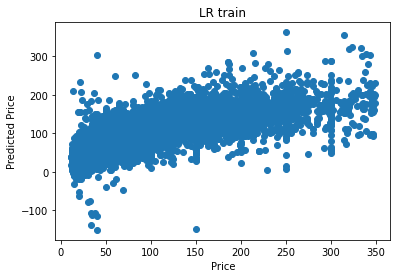

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


lr = LinearRegression()

lr.fit(X, y)


y_pred = lr.predict(X)



print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))


plt.scatter(y, y_pred)
plt.title('LR train')
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

----- EVALUATION ON TEST SET ------
RMSE 46.40563828781658
MAE 32.26821059770168
R^2:  0.554953291510842


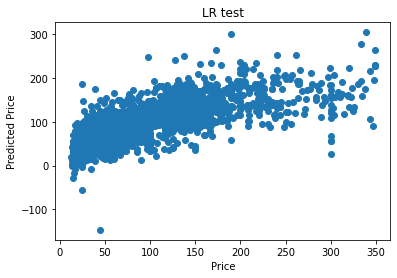

In [ ]:
y_pred_test = lr.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.title('LR test')
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

### Model training: KNN

----- EVALUATION ON TRAIN SET ------
RMSE 35.70462032418106
MAE 23.873675255226058
R^2:  0.7314175112342028


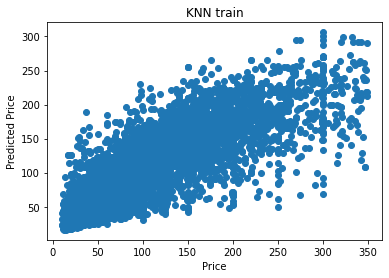

In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

n_neighbors = 10
knn = neighbors.KNeighborsRegressor(n_neighbors)
knn.fit(X, y)

y_pred = knn.predict(X)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))


plt.scatter(y, y_pred)
plt.title('KNN train')
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

### Model test: KNN

----- EVALUATION ON TEST SET ------
RMSE 39.04584401960207
MAE 25.988636363636363
R^2:  0.6849251615015703


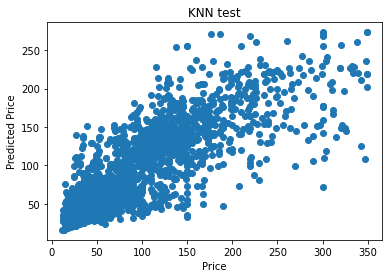

In [ ]:
y_pred_test = knn.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.title('KNN test')
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.show()

## Random forest

----- EVALUATION ON TRAIN SET ------
RMSE 13.811088977630716
MAE 9.210722857793865
R^2:  0.9598130819038674
OOB SCORE 0.7091262947922183


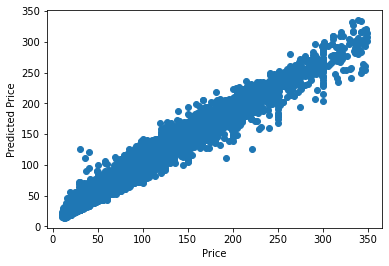

In [ ]:
from sklearn.ensemble import RandomForestRegressor


'''param_grid =  {'n_estimators': [300],
     'max_features': [3,4,5],
     'max_depth':[30,40,50],
     'bootstrap': [True],
     'oob_score': [True]
}'''

'''
Best params
param_grid =  {'n_estimators': [300],
     'max_features': [3],
     'max_depth':[40],
     'bootstrap': [True],
     'oob_score': [True]
}'''

'''forest_reg = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)'''

forest_reg = RandomForestRegressor(random_state = 42, n_estimators = 300, max_features = 3, max_depth = 40, bootstrap = True, oob_score = True)

model = forest_reg.fit(X, y)

y_pred = model.predict(X)



print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y, y_pred)))
print("MAE", mean_absolute_error(y, y_pred))
print("R^2: ",r2_score(y, y_pred))
print("OOB SCORE", model.oob_score_)

plt.scatter(y, y_pred)
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

## Random forest test

----- EVALUATION ON TEST SET ------
RMSE 36.746353152804325
MAE 24.267769845452026
R^2:  0.7209432182858249


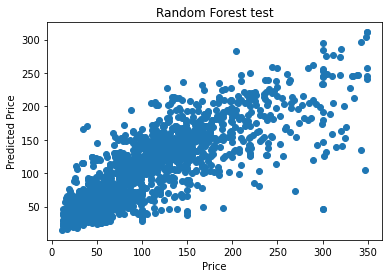

In [ ]:
y_pred_test = model.predict(X_test)

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("MAE", mean_absolute_error(y_test, y_pred_test))
print("R^2: ",r2_score(y_test, y_pred_test))


plt.scatter(y_test, y_pred_test)
plt.title('Random Forest test')
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

## Neural network

In [ ]:
def create_NN_model(opt = 'Adam',
                      learning_rate = 0.001):

    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=X.shape[1], kernel_regularizer='l2'))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))

    optimizer = getattr(optimizers, opt)(learning_rate = learning_rate)

    model.compile(loss = 'mse',
                  optimizer = optimizer,
                  metrics = ['mae'])
    return model

NN_model = create_NN_model(opt = 'Adam',
                               learning_rate = 1e-4)
print(NN_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              11264     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,061,889
Trainable params: 1,061,889
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
ep = 200

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
x = np.asarray(X).astype('float32')

NN_history = NN_model.fit(x, y, epochs = ep, verbose = 1, validation_split=0.2, callbacks = [es])

Epoch 1/200
206/206 [==============================] - 4s 6ms/step - loss: 8359.8320 - mae: 65.9938 - val_loss: 4188.1265 - val_mae: 45.4352
Epoch 2/200
206/206 [==============================] - 1s 5ms/step - loss: 3059.8162 - mae: 38.5661 - val_loss: 2027.4291 - val_mae: 32.5995
Epoch 3/200
206/206 [==============================] - 1s 5ms/step - loss: 2321.1780 - mae: 34.1725 - val_loss: 1816.8589 - val_mae: 29.8088
Epoch 4/200
206/206 [==============================] - 1s 5ms/step - loss: 2239.5620 - mae: 32.5145 - val_loss: 1750.9731 - val_mae: 29.0243
Epoch 5/200
206/206 [==============================] - 1s 5ms/step - loss: 2181.8088 - mae: 31.7734 - val_loss: 1751.7407 - val_mae: 28.4965
Epoch 6/200
206/206 [==============================] - 1s 6ms/step - loss: 2144.4658 - mae: 31.4316 - val_loss: 1726.1140 - val_mae: 28.6434
Epoch 7/200
206/206 [==============================] - 1s 6ms/step - loss: 2137.6165 - mae: 31.5389 - val_loss: 1691.9429 - val_mae: 28.2644
Epoch 8/200
2

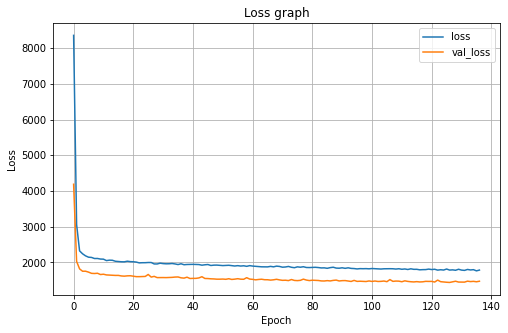

In [ ]:
pd.DataFrame(NN_history.history)[['loss','val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

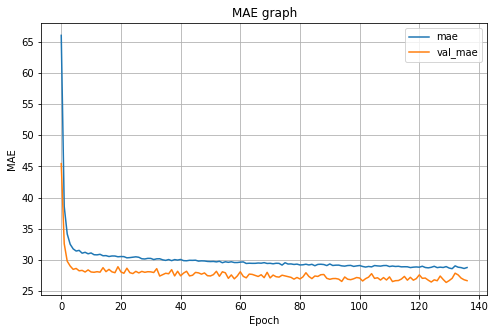

In [ ]:
pd.DataFrame(NN_history.history)[['mae','val_mae']].plot(figsize=(8, 5))
plt.grid(True)
plt.title('MAE graph')
plt.ylabel('MAE')
plt.xlabel('Epoch')
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

In [ ]:
y_pred_nn = NN_model.predict(np.asarray(X_test).astype('float32'))

----- EVALUATION ON TEST SET ------
RMSE 41.33353406092092
MAE 27.50986122301054
R^2:  0.6469232085888272


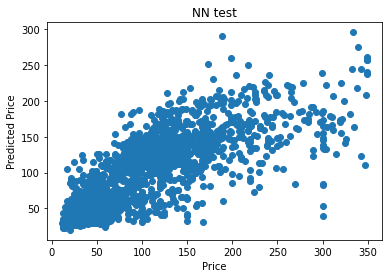

In [ ]:

print("----- EVALUATION ON TEST SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred_nn)))
print("MAE", mean_absolute_error(y_test, y_pred_nn))
print("R^2: ",r2_score(y_test, y_pred_nn))


plt.scatter(y_test, y_pred_nn)
plt.title('NN test')
plt.xlabel('Price')
plt.ylabel('Predicted Price');
plt.show()

### Proves

In [ ]:
y_pred_rf = model.predict(X_test)

(array([  2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   2.,   2.,   1.,   0.,   0.,   0.,   2.,   1.,
          2.,   1.,   0.,   1.,   1.,   1.,   0.,   1.,   2.,   2.,   2.,
          2.,   1.,   3.,   6.,   3.,   3.,   3.,   3.,   6.,   7.,   3.,
          5.,   8.,   9.,   4.,   7.,  14.,  14.,   5.,   6.,  15.,   9.,
          9.,  15.,  18.,  15.,  20.,  29.,  17.,  29.,  32.,  37.,  43.,
         57.,  53.,  67.,  99., 112., 128., 133., 122., 112., 103., 115.,
         85.,  76.,  52.,  55.,  47.,  33.,  28.,  22.,  27.,  18.,  14.,
          6.,  12.,   8.,   7.,   6.,   6.,   4.,   7.,   6.,   7.,   3.,
          1.,   1.,   3.,   2.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.]),
 array([-254.23333333, -251.15066667, -248.068     , -244.98533333,
        -241.90266667, -238.82      , -235.73733333, -232.65466667,
        -229.572

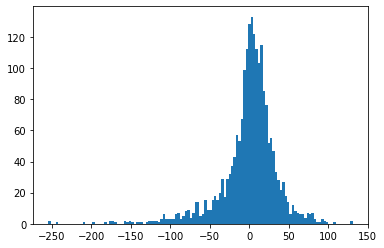

In [ ]:
error = y_pred_rf - y_test
plt.hist(error, bins = 125)

